In [ ]:
# demo: loads file with all messages (CSTARTTIME, CSENDERENDPOINTID, ymdhm )
# show some charts, anomaly detection with LSTM autoencoders

In [2]:
import dfBasics
import common
import encoder
import pfAdapt
import charts
import anomaly

Setup Complete
Setup Complete


In [3]:
import pandas as pd
from pyspark.sql import functions

In [4]:
sparkSession = dfBasics.getSparkSession()
df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/CSENDERENDPOINTID/CSENDERENDPOINTID_9.parquet')
pfall = df.toPandas()

In [ ]:
#pfall = pd.read_parquet('/tmp/msgsenders_0702.parquet', engine='fastparquet')
pfall = pd.read_parquet('/tmp/sla_1580137124017.parquet', engine='pyarrow')
#pfall = pd.read_parquet('/tmp/sla_1580199488133.parquet', engine='pyarrow')

In [ ]:
#adddatecolumns(pfall,pfall,'CSTARTTIME')
#pfall.dtypes
#pfall.dtypes
#!ls -l /tmp/sla_*.parquet

In [ ]:
from datetime import time
import datetime as dt
import calendar
import pytz
de = pytz.timezone('Europe/Berlin')

# long timestamp
def date(x):
    return  dt.datetime.fromtimestamp(float(x) / 1e3, tz=de)


def adddatecolumns(data,pf,column) :
    data['year'] = pf[column].apply(lambda x: date(x).date().year)
    data['month'] = pf[column].apply(lambda x: date(x).date().month)
    data['day'] = pf[column].apply(lambda x: date(x).date().day)
    data['hour'] = pf[column].apply(lambda x: date(x).time().hour)
    data['minute'] = pf[column].apply(lambda x: date(x).time().minute)
    #data['second'] = pf[column].apply(lambda x: x.time().second)
    #data['microsecond'] = pf[column].apply(lambda x: x.time().microsecond)

def converttimestampcolumnn(pf,tsc) :
    pf[tsc] = pf[tsc].apply(lambda x: dt.datetime.fromtimestamp(float(x) / 1e3))

In [19]:
## Setup charts
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

def get_ym_string(a,b) :
    return a + "-" + b
    #return a.join(["-",b]) 

def get_ym(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    return a,b

def get_ymd(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    return a,b,c

def get_ymd_string(a,b,c) :
    return a + "-" + b + "-" + c 

def get_ymdh(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    d = mdcountsall.index.get_level_values(3).astype(str)
    return a,b,c,d

def get_ymdh_string(a,b,c,d) :
    return a + "-" + b + "-" + c + "-" + d

def createData_ym(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month'])['year'].count()    
    a,b = get_ym(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ym_string(a,b)
    data2['outcome'] = mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int) 
    return data2

def createData(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month','day','hour'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month','day','hour'])['year'].count()    
    a,b,c,d = get_ymdh(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymdh_string(a,b,c,d)
    data2['outcome'] =  mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int)

    #for pivot table
    data2['hours'] =  d.astype(int) 
    data2['days']  =  c.astype(int) 
    return data2

def createData_ymd(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month','day'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month','day'])['year'].count()    
    a,b,c = get_ymd(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymd_string(a,b,c)
    data2['outcome'] = mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int) 
    return data2

def label(graph,skip,rot) :
    for ind, label in enumerate(graph.get_xticklabels()):
        if ind % skip == 0:  # every 10th label is kept
            label.set_visible(True)
            label.set_rotation(rot)
        else:
            label.set_visible(False)

def createBarplot(md=None,fx=24,fy=12,fontscale=3.0,title="") :
    sns.set(style='whitegrid', palette='muted', font_scale=fontscale)
    plt.figure(figsize=(fx,fy))
    plt.title(title)
    ax = sns.barplot(x=md['date'], y=md['outcome'], data=md)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=75 )
    plt.tight_layout()
    plt.show()
    return ax

## heatmap
def createHeatmap(piv,title="") :
    plt.figure(figsize=(24,8))
    plt.title(title)
    ax = sns.heatmap(piv, square=True)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 )
    plt.tight_layout()
    plt.show()
    return ax

Setup Complete


# Charts

In [ ]:
md = createData_ym(pfall,0)
ax=createBarplot(md,24,12,3.0,title="number messages sent by all endpoints")
#label(ax,1000,90)

In [ ]:
md = createData_ymd(pfall,1)
ax=createBarplot(md,fx=24,fy=12,fontscale=3.0,title="number messages sent by all endpoints")
label(ax,1000,90)


In [18]:
import ipywidgets as widgets
from IPython.display import display, clear_output
style = {'description_width': '250px'}
layout = {'width': '500px'}

def createHeatmapPfall(pfall=pfall,sender='all',month=1):
    data2 = createData(pfall,month)
    piv = pd.pivot_table(data2, values="outcome",index=["hours"], columns=["days"], fill_value=0)
    #titlestring = "CSENDERENDPOINTID: " + str(topsender.iloc[7]['CSENDERENDPOINTID']) + ": "+ category + " so far = " + str(topsender.iloc[7]['outcome']) + " , month: " + str(month) 
    #titlestring = "CSENDERENDPOINTID: " + str(topsender.iloc[7]['CSENDERENDPOINTID']) + ": "+ category  + " month: " + str(month) 
    titlestring ="number messages 2020-" + str(month) + " sender: " + sender
    sns.set(style='whitegrid', palette='muted', font_scale=1.2)
    createHeatmap(piv, titlestring)
    

def monthw_on_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            with out:
                clear_output()
                createHeatmapPfall(pfall=pfall,sender='all',month=1)

            
options = [1,2,3,4,5,6,7,8,9,10,11,12]
monthw = widgets.Dropdown(options=options,  description='month', value = 1,style=style, layout=layout)
monthw.observe(monthw_on_change,'value') 
display(monthw)
out = widgets.Output()
display (out)

Dropdown(description='month', layout=Layout(width='500px'), options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), s…

Output()

In [ ]:
out.widgets

In [ ]:
createHeatmapPfall(pfall,'all',6)

# Top senders

In [ ]:
#pd.unique(mdcountsall[1].index.get_level_values(0))
def getTopSenders(TOP):
    result = pfall.groupby(['CSENDERENDPOINTID']).count()
    data2 = pd.DataFrame()
    data2['date'] = result.index.get_level_values(0).astype(str)
    data2['outcome'] =  result['CSTARTTIME'].astype(int)
    topsender =  data2[data2['outcome'] > TOP].sort_values('outcome', ascending=False).reset_index()
    topsender['outcome'] = topsender['outcome'].astype(int)
    topsender.columns = ['index', 'CSENDERENDPOINTID', 'count']
    return topsender

#topsender = getTopSenders(500000)
topsender = getTopSenders(1000)
topsender

In [ ]:
numbersenders = len(pfall['CSENDERENDPOINTID'].unique())
print('sending endpoints: '  + str(numbersenders))

In [ ]:
sender = topsender.iloc[0]['index']
pfall1 = pfall[pfall['CSENDERENDPOINTID'] == sender].sort_values('CSTARTTIME').reset_index() 

def get_datestr(row):
    return str(row.day) + "." + str(row.month) + "." + str(row.year) 

In [ ]:
createHeatmapPfall(pfall1,str(sender),1)

In [5]:
pfall1 = pfall.sort_values(['year','month','day','hour']).reset_index()
del pfall1['index']
del pfall1['CGLOBALMESSAGEID']

In [ ]:
pfall1

# Time Series Anomaly Detection with LSTM Autoencoders (selected sender)

In [ ]:
import os
os.environ['http_proxy'] = "http://172.30.12.56:3128" 
os.environ['https_proxy'] = "https://172.30.12.56:3128" 
#!pip install --trusted-host pypi.python.org pytest-xdist
#!pip install --trusted-host pypi.python.org --upgrade pip
#!pip install --trusted-host pypi.python.org tensorflow
#!pip3 install --user --upgrade tensorflow 
#!pip install tensorflow==2.4.1
#!pip install --trusted-host pypi.python.org python==3.7
#!pip install --upgrade pip --trusted-host pypi.org --trusted-host files.pythonhosted.org
#!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org tensorflow==2.4.1

In [ ]:
import anomaly
anomaly.init_sns()
#pip3 install --trusted-host pypi.org --trusted-host files.pythonhosted.org numpy==1.18.5

In [ ]:
df1 = anomaly.createDataframe(pfall)
perc_train=0.94
train, test = anomaly.getTrainAndTest(df1,perc_train)
OUTCOME = 'close'
scaler = anomaly.StandardScaler()
scaler = scaler.fit(train[[OUTCOME]])
train[OUTCOME] = scaler.transform(train[[OUTCOME]])
test[OUTCOME] = scaler.transform(test[[OUTCOME]])

In [ ]:
TIME_STEPS = 12
X_train, y_train = anomaly.create_dataset(train[[OUTCOME]], train.close, TIME_STEPS)
X_test, y_test = anomaly.create_dataset(test[[OUTCOME]], test.close, TIME_STEPS)
print(X_train.shape)

In [ ]:
!pip install -U numpy==1.18.5

In [ ]:
#model = anomaly.initmodel(X_train)

from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.LSTM(256, input_shape=(1, 66), return_sequences=True))

model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
 
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [6]:
import AnomalyDetectionLSTMAutoencoder
anomalyEnc = AnomalyDetectionLSTMAutoencoder.AnomalyDetectionLSTMAutoencoder()
anomalyEnc.initAndTrain(pfall1,0.94)
#anomalyEnc.__dict__

train.shape:  (11724, 1) test.shape:  (749, 1)


/home/jovyan/work/scray/scray-examples/python/AnomalyDetectionLSTMAutoencoder.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train[self.OUTCOME] = self.scaler.transform(self.train[[self.OUTCOME]])
/home/jovyan/work/scray/scray-examples/python/AnomalyDetectionLSTMAutoencoder.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test[self.OUTCOME] = self.scaler.transform(self.test[[self.OUTCOME]])


Epoch 1/10
330/330 [==============================] - 12s 27ms/step - loss: 0.1851 - val_loss: 0.1080
Epoch 2/10
330/330 [==============================] - 8s 23ms/step - loss: 0.1452 - val_loss: 0.0945
Epoch 3/10
330/330 [==============================] - 8s 23ms/step - loss: 0.1343 - val_loss: 0.0921
Epoch 4/10
330/330 [==============================] - 8s 23ms/step - loss: 0.1295 - val_loss: 0.0872
Epoch 5/10
330/330 [==============================] - 7s 23ms/step - loss: 0.1251 - val_loss: 0.0906
Epoch 6/10
330/330 [==============================] - 8s 23ms/step - loss: 0.1239 - val_loss: 0.1001
Epoch 7/10
330/330 [==============================] - 7s 23ms/step - loss: 0.1242 - val_loss: 0.0947
Epoch 8/10
330/330 [==============================] - 8s 23ms/step - loss: 0.1206 - val_loss: 0.0980
Epoch 9/10
330/330 [==============================] - 7s 23ms/step - loss: 0.1191 - val_loss: 0.1056
Epoch 10/10
330/330 [==============================] - 8s 23ms/step - loss: 0.1181 - val_l

In [14]:
#anomalyEnc.model.save("/tmp/my_model/",save_format="tf")
anomalyEnc.model.save("/tmp/mymodel.h5", save_format="h5")

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.6412632434878853, 0.12171660129414517)

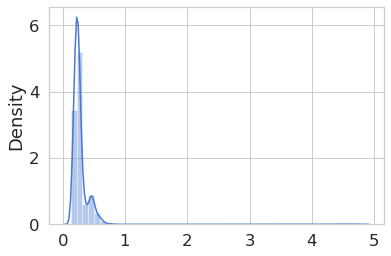

In [21]:
data = sns.distplot(anomalyEnc.train_mae_loss, bins=50, kde=True).get_lines()[0].get_data()
data[0][25], data[1][25]

In [24]:
test_score_df = anomalyEnc.testScoreDF(anomalyEnc.model, data[0][25],anomalyEnc.X_test,anomalyEnc.test)
anomalies     = test_score_df[test_score_df.anomaly == True]

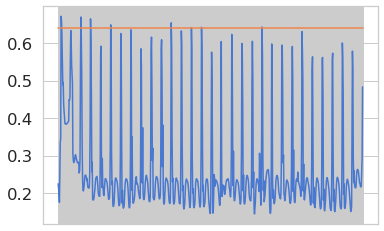

In [28]:
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
#plt.xticks(rotation=25)
#plt.legend();

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


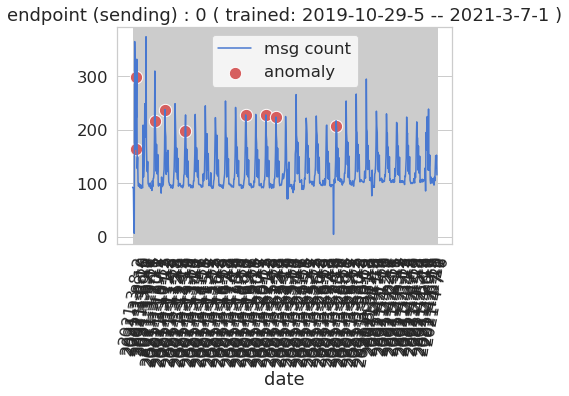

In [32]:
sender = 0
titlestring ="endpoint (sending) : " + str(sender) + " ( trained: " +  anomalyEnc.train.index[0] + " -- " + anomalyEnc.train.index[len(anomalyEnc.train.index)-1] + " )"
anomaly.plot_test(anomalyEnc.test,anomalyEnc.scaler,anomalies,titlestring)

In [ ]:
model,scaler,train,test,X_test,X_train,X_train_pred,train_mae_loss = anomaly.initAndTrain(pfall1,0.94)

In [ ]:
data = sns.distplot(train_mae_loss, bins=50, kde=True).get_lines()[0].get_data()

In [ ]:
data[0][25], data[1][25]

In [ ]:
test_score_df = anomaly.testScoreDF(model, 0.65,X_test,test)
anomalies     = test_score_df[test_score_df.anomaly == True]

In [ ]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [ ]:
sender = 0
titlestring ="endpoint (sending) : " + str(sender) + " ( trained: " +  train.index[0] + " -- " + train.index[len(train.index)-1] + " )"
anomaly.plot_test(test,scaler,anomalies,titlestring)